Simulation

In [1]:
import numpy as np
import pandas as pd

In [2]:
n_clusters = 8
Q = 2
n_genes = 250

In [3]:
prop1 = [0.3,0.15,0.2,.05,0.1,.07,.03,0.1]
prop2 = [0.3,0.25,0.0,.05,0.1,.17,.13,0.0]

In [4]:
np.random.seed(51)

In [5]:
centers = np.random.normal(0,1,(n_clusters,Q))

In [6]:
import matplotlib.pyplot as plt

In [7]:
N1 = 300
N2 = 200

In [8]:
b1_cluster = np.random.multinomial(1,prop1,size = N1)
b1_latent = np.random.normal(loc = np.matmul(b1_cluster, centers), scale = 0.05)

b2_cluster = np.random.multinomial(1,prop2,size = N2)
b2_latent = np.random.normal(loc = np.matmul(b2_cluster, centers), scale = 0.05)

In [9]:
clusters_total = np.concatenate((b1_cluster,b2_cluster),axis = 0)
clusters_total.shape

(500, 8)

In [10]:
b1_cluster

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

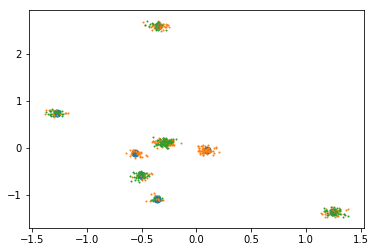

In [11]:
plt.scatter(centers[:,0],centers[:,1], s = 50.0)
plt.scatter(b1_latent[:,0],b1_latent[:,1], s = 1.0)
plt.scatter(b2_latent[:,0],b2_latent[:,1], s = 1.0)
plt.show()

In [12]:
from sklearn.decomposition import PCA

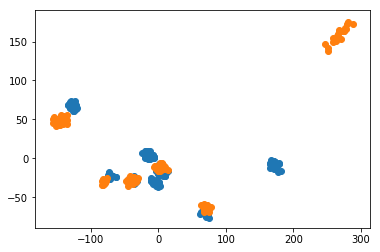

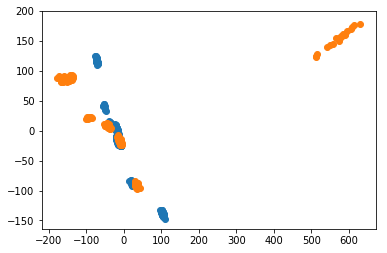

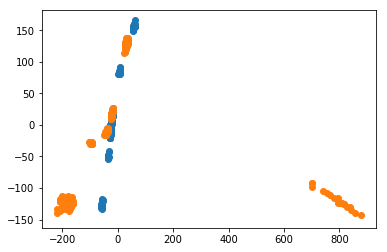

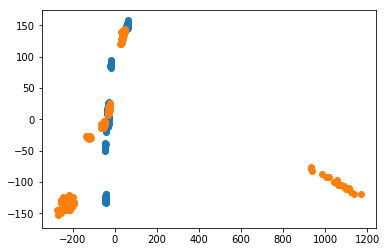

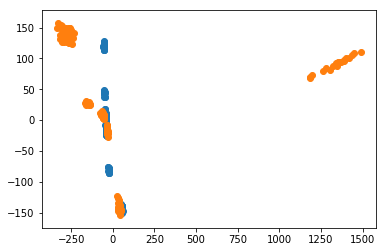

In [13]:
proj_vector = np.random.normal(0,5,size = (Q, n_genes))

for i in range(1,6):
    batch_vector = np.random.normal(0,i,size = (Q,n_genes))
    Y1 = np.matmul(b1_latent,proj_vector) + np.matmul(np.power(b1_latent,2),0.1*batch_vector)
    Y2 = np.matmul(b2_latent,proj_vector) + 2 + np.matmul(np.power(b2_latent,3),batch_vector)
    Y3 = np.concatenate((Y1,Y2),axis = 0)
    Y = np.random.normal(Y3, 1)
    fname = './batch-effect-noise/sim-cluster-' + str(i) + '.csv'
    np.savetxt(fname,Y)
    
    Y2_counterfactual = np.matmul(b2_latent,proj_vector) + np.matmul(np.power(b2_latent,2),0.1*batch_vector)
    Y1_counterfactual = np.matmul(b1_latent,proj_vector) + 2 + np.matmul(np.power(b1_latent,3),batch_vector)
    Yc = np.concatenate((Y1_counterfactual,Y2_counterfactual),axis = 0)
    fname = './batch-effect-noise/sim-cluster-' + str(i) + '-counterfactual.csv'
    np.savetxt(fname,Yc)
    
    pca = PCA(n_components = 2)
    z = pca.fit_transform(Y)
    plt.scatter(z[:N1,0],z[:N1,1])
    plt.scatter(z[N1:,0],z[N1:,1])
    plt.show()

In [14]:
np.savetxt('./batch-effect-noise/clusters.csv',clusters_total)

In [15]:
latent_true = np.concatenate([b1_latent, b2_latent], axis = 0)
latent_true.shape
np.save('./batch-effect-noise/latent_true.npy',latent_true)

In [16]:
batch_var = np.concatenate((np.zeros((N1,1)),np.ones((N2,1))),axis = 0)
batch_var.shape

(500, 1)

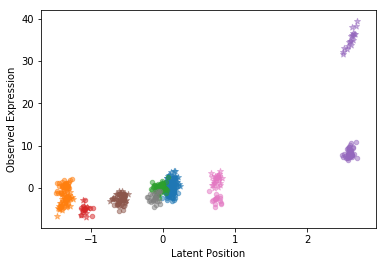

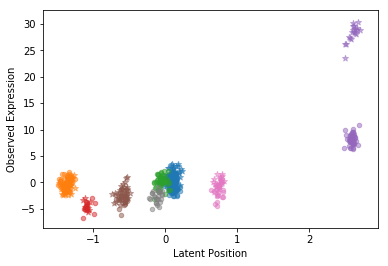

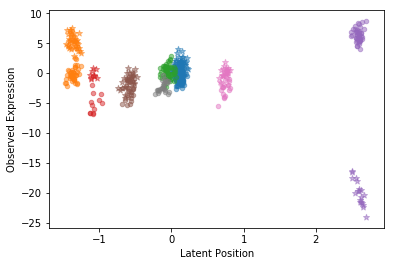

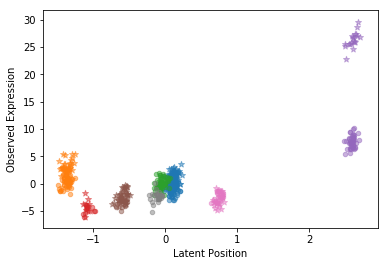

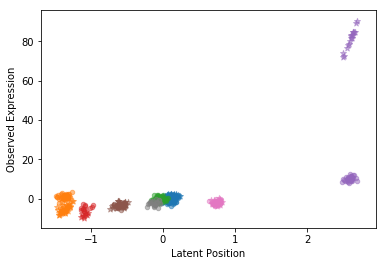

In [17]:
for i in range(1,6):
    Y = np.loadtxt('./batch-effect-noise/sim-cluster-'+str(i)+'.csv')
    b1 = latent_true[:N1,:]
    b2 = latent_true[N1:]
    Y1 = Y[:N1]
    Y2 = Y[N1:]
    for i in range(0,n_clusters):
        c = 'C' + str(i)
        mask1 = clusters_total[:N1,i] == 1
        plt.scatter(b1[mask1,1],Y1[mask1,1], c = c, marker = 'o', s = 20, alpha = 0.5)
        mask2 = clusters_total[N1:,i] == 1 
        plt.scatter(b2[mask2,1],Y2[mask2,1], c = c, marker = '*', s = 40, alpha = 0.5)
        plt.xlabel('Latent Position')
        plt.ylabel('Observed Expression')
    plt.show()

GPy

In [18]:
folder = 'batch-effect-noise'

In [19]:
import GPy

In [20]:
gpy_fits = np.zeros((5,N1+N2,Q))

In [21]:
for i in range(1,6):
    print(i)
    Y = np.loadtxt('./'+folder+'/sim-cluster-' + str(i) + '.csv')
    X = np.expand_dims(np.concatenate((np.zeros(N1),np.ones(N2))), axis = 1)
    m = GPy.models.GPRegression(X,Y)
    m.optimize()
    corrected_zero = m.predict(X)
    y2 = Y - corrected_zero[0]
    m2 = GPy.models.GPLVM(y2, Q)
    m2.optimize()
    gpy_fits[i-1] = m2['latent_mean']

1
2
3
4
5


In [22]:
print(m2)


Name : GPLVM
Objective : 197227.412087
Number of Parameters : 1005
Number of Optimization Parameters : 1005
Updates : True
Parameters:
  GPLVM.                   |               value  |  constraints  |  priors
  latent_mean              |            (500, 2)  |               |        
  sum.rbf.variance         |  169.30321339248977  |      +ve      |        
  sum.rbf.lengthscale      |                (2,)  |      +ve      |        
  sum.bias.variance        |   9.731601101809252  |      +ve      |        
  Gaussian_noise.variance  |  0.9957513552284037  |      +ve      |        


In [23]:
m2['sum.rbf.lengthscale'] * np.ones(Q)

array([0.91038794, 2.97151213])

1


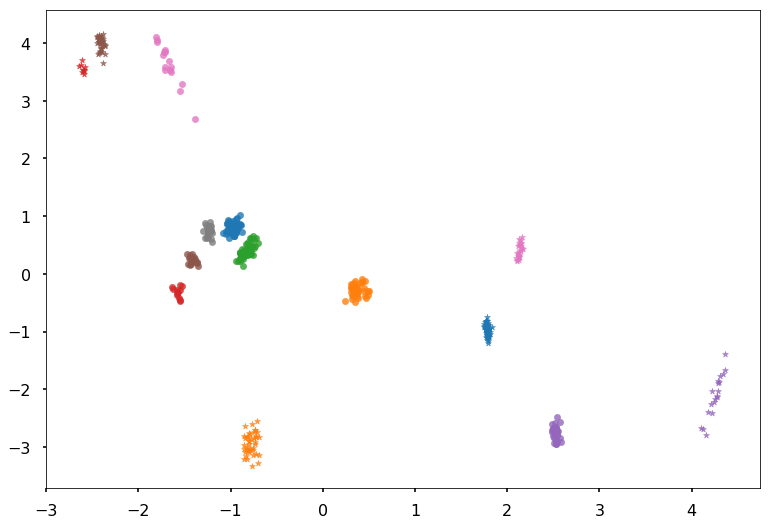

2


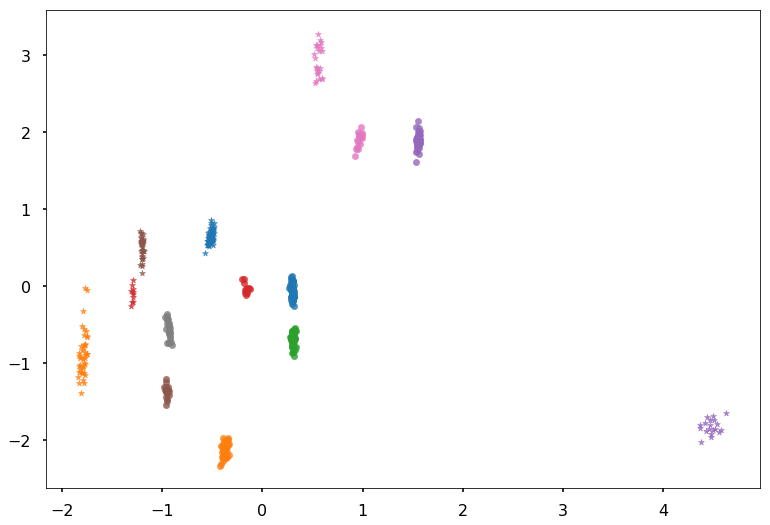

3


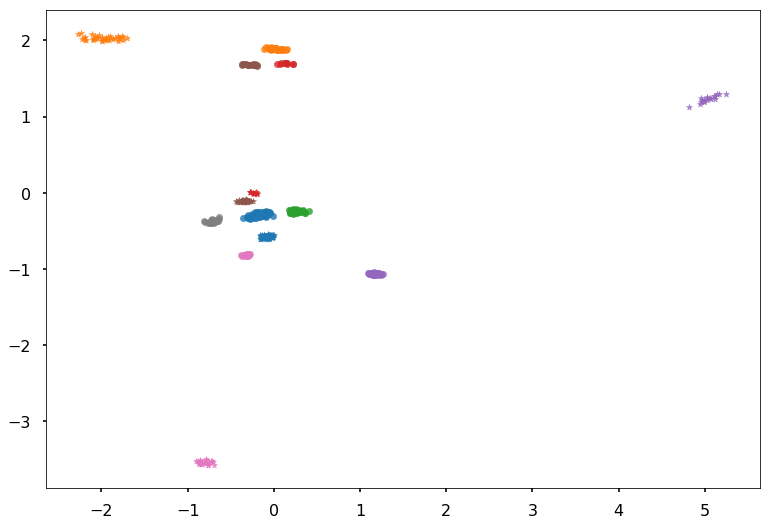

4


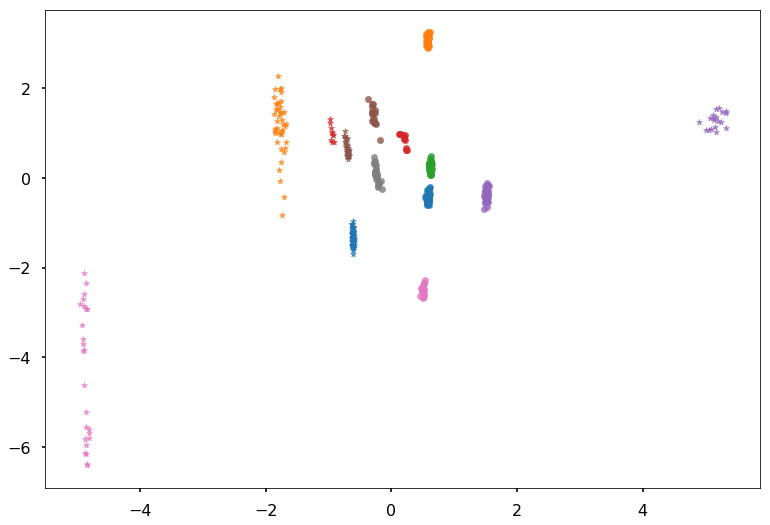

5


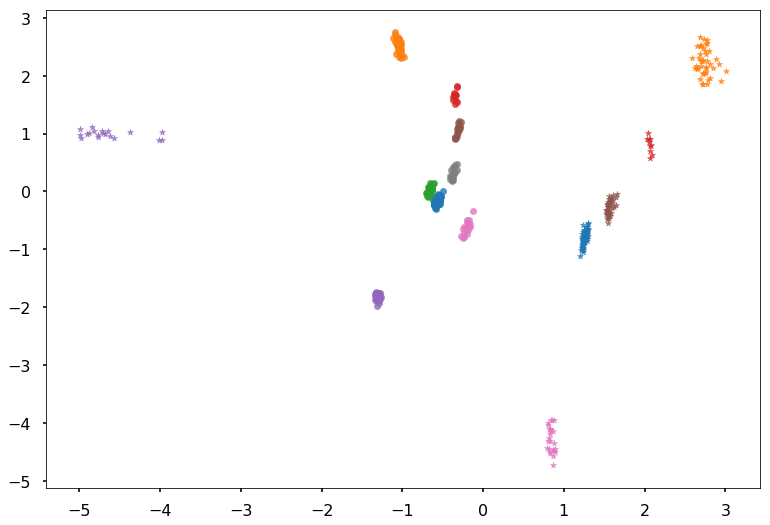

In [24]:
for j in range(1,6):
    print(j)
    zfit = gpy_fits[j-1]
    plt.style.use('seaborn-poster')
    b1 = zfit[:N1,:]
    b2 = zfit[N1:]

    plt.set_cmap('Pastel1')

    for i in range(0,n_clusters):
        c = 'C' + str(i)
        mask1 = clusters_total[:N1,i] == 1
        plt.scatter(b1[mask1,0],b1[mask1,1], c = c, marker = 'o', s = 40.0, alpha = 0.8)
        mask2 = clusters_total[N1:,i] == 1 
        plt.scatter(b2[mask2,0],b2[mask2,1], c = c, marker = '*', s = 40.0, alpha = 0.8)
    plt.show()

Results

In [25]:
import h5py

In [26]:
from mpl_toolkits.mplot3d import Axes3D

1


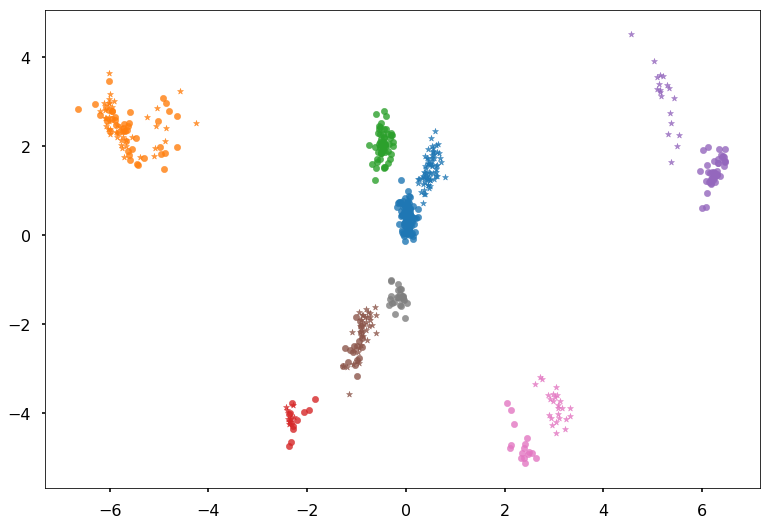

2


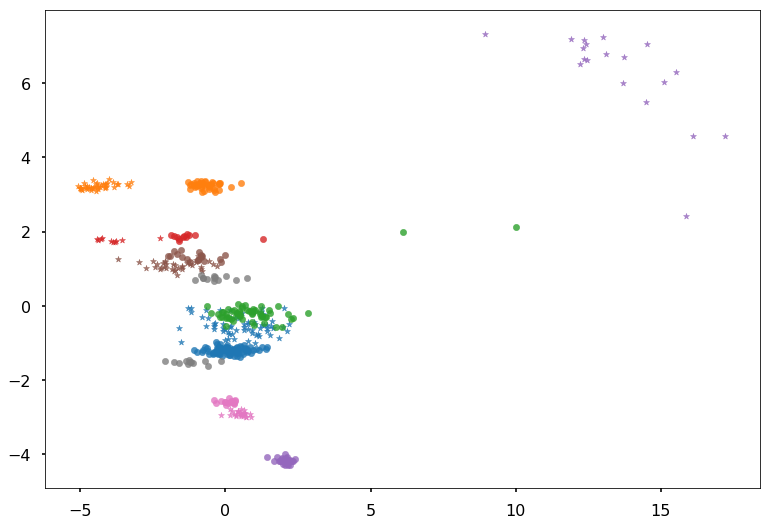

3


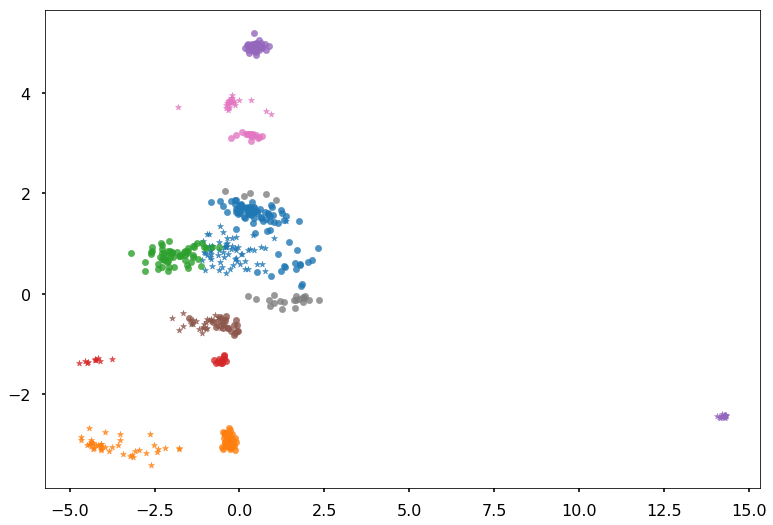

4


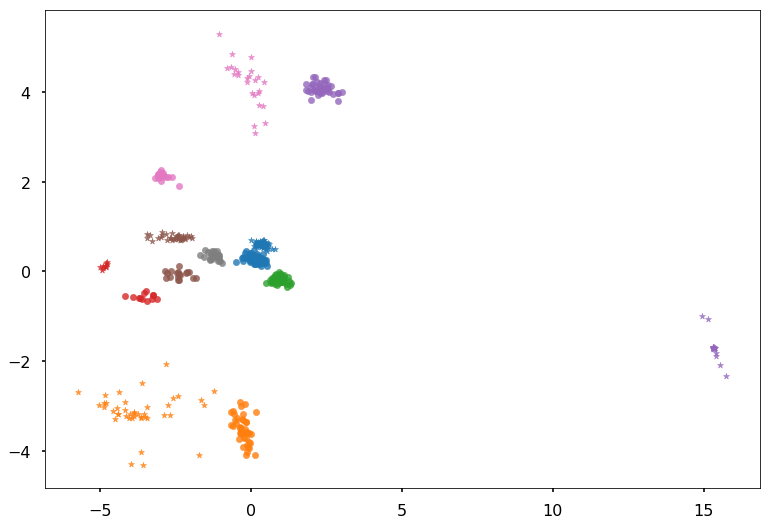

5


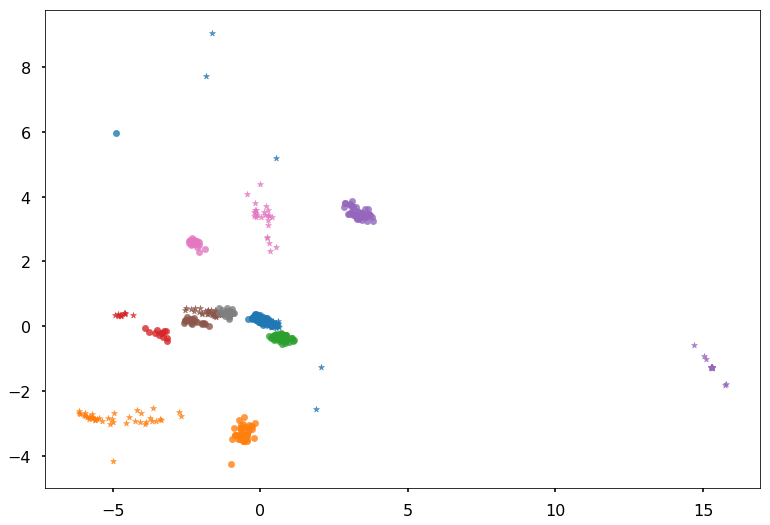

In [27]:
for j in range(1,6):
    print(j)
    path = './'+ folder + '/matern/rand-lin/' + str(j) + '/model-output-final.hdf5'
    fit = h5py.File(path, 'r')
    zfit = fit['x_mean']
    plt.style.use('seaborn-poster')
    b1 = zfit[:N1,:]
    b2 = zfit[N1:]

    plt.set_cmap('Pastel1')

    for i in range(0,n_clusters):
        c = 'C' + str(i)
        mask1 = clusters_total[:N1,i] == 1
        plt.scatter(b1[mask1,0],b1[mask1,1], c = c, marker = 'o', s = 40.0, alpha = 0.8)
        mask2 = clusters_total[N1:,i] == 1 
        plt.scatter(b2[mask2,0],b2[mask2,1], c = c, marker = '*', s = 40.0, alpha = 0.8)
    plt.show()

In [28]:
from sklearn.linear_model import LinearRegression

In [29]:
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import normalize

In [30]:
dist_true = squareform(pdist(latent_true))
dist_norm = normalize(dist_true, norm = 'l1')

In [31]:
import ot

In [32]:
M = dist_true

In [33]:
w2z = np.zeros((2,5,500))
w2p = np.zeros((2,5,500))
w2s = np.zeros((2,5,500))
w2m = np.zeros((2,5,500))
w2b = np.zeros((5,500))

for i in range(1,6):
    Y = np.loadtxt('./'+folder+'/sim-cluster-' + str(i) + '.csv')
    dist_obs = squareform(pdist(Y))
    dist_obs_norm = normalize(dist_obs, norm = 'l1')
    
    path = './'+folder+'/matern/rand-lin/' + str(i) + '/model-output-final.hdf5'
    fit = h5py.File(path, 'r')
    zfit = fit['x_mean']
    
    dist_z = squareform(pdist(np.divide(zfit, fit['lengthscales'][0:2,0])))
    dist_z_norm = normalize(dist_z, norm = 'l1')
    
    ols = LinearRegression(fit_intercept = False)
    ols.fit(batch_var, Y)
    Yres = Y - ols.predict(batch_var)
    pca = PCA(n_components = 3)
    zpca = pca.fit_transform(Yres)
    
    dist_pca = squareform(pdist(zpca))
    dist_pca_norm = normalize(dist_pca, norm = 'l1')
    
    seurat = pd.read_csv('./'+folder+'/results/seurat-results/sim-' + str(i) + '.csv')
    dist_seurat = squareform(pdist(seurat.values))
    dist_s_norm = normalize(dist_seurat, norm = 'l1')

    mnn = pd.read_csv('./'+folder+'/results/mnn-results/sim-' + str(i) + '.csv')
    dist_m = squareform(pdist(mnn.values))
    dist_m_norm = normalize(dist_m, norm = 'l1')
    
    for j in range(0,500):
        w2z[0,i-1,j] = ot.emd2(dist_z_norm[j,:],dist_norm[j,:],M)
        w2z[1,i-1,j] = ot.emd2(dist_z_norm[j,:],dist_obs_norm[j,:],M)
        
        w2p[0,i-1,j] = ot.emd2(dist_pca_norm[j,:],dist_norm[j,:],M)
        w2p[1,i-1,j] = ot.emd2(dist_pca_norm[j,:],dist_obs_norm[j,:],M)
        
        w2s[0,i-1,j] = ot.emd2(dist_s_norm[j,:],dist_norm[j,:],M)
        w2s[1,i-1,j] = ot.emd2(dist_s_norm[j,:],dist_obs_norm[j,:],M)
        
        w2m[0,i-1,j] = ot.emd2(dist_m_norm[j,:],dist_norm[j,:],M)
        w2m[1,i-1,j] = ot.emd2(dist_m_norm[j,:],dist_obs_norm[j,:],M)
        
        w2b[i-1,j] = ot.emd2(dist_norm[j,:],dist_obs_norm[j,:],M)

In [34]:
w2gpy = np.zeros((2,5,500))
for i in range(1,6):
    print(i)
    Y = np.loadtxt('./'+folder+'/sim-cluster-' + str(i) + '.csv')
    dist_obs = squareform(pdist(Y))
    dist_obs_norm = normalize(dist_obs, norm = 'l1')
    #path = './'+folder+'/results/matern/rand/simulate-' + str(i) + '/model-output-final.hdf5'
    #fit = h5py.File(path, 'r')
    zfit = gpy_fits[i-1]
    dist_z = squareform(pdist(np.divide(zfit, fit['lengthscales'][0:2,0])))
    dist_z_norm = normalize(dist_z, norm = 'l1')
    for j in range(0,500):
        w2gpy[0,i-1,j] = ot.emd2(dist_z_norm[j,:],dist_norm[j,:],M)
        w2gpy[1,i-1,j] = ot.emd2(dist_z_norm[j,:],dist_obs_norm[j,:],M)

1
2
3
4
5


In [38]:
# np.save(folder + '/results/w2-distance/w2z',w2z)
# np.save(folder + '/results/w2-distance/w2p',w2p)
# np.save(folder + '/results/w2-distance/w2s',w2s)
# np.save(folder + '/results/w2-distance/w2m',w2m)
# np.save(folder + '/results/w2-distance/w2b',w2b)
# np.save(folder + '/results/w2-distance/w2gpy-w-lvm',w2gpy)
#np.save(folder + '/results/w2-distance/w2r',w2r)

w2z = np.load(folder + '/results/w2-distance/w2z.npy')
w2p = np.load(folder + '/results/w2-distance/w2p.npy')
w2s = np.load(folder + '/results/w2-distance/w2s.npy')
w2m = np.load(folder + '/results/w2-distance/w2m.npy')
w2b = np.load(folder + '/results/w2-distance/w2b.npy')
#w2r = np.load(folder + '/results/w2-distance/w2r.npy')
w2gpy = np.load(folder + '/results/w2-distance/w2gpy-w-lvm.npy')

In [ ]:
#np.save(folder + '/results/w2-distance/w2rbf',w2rbf)

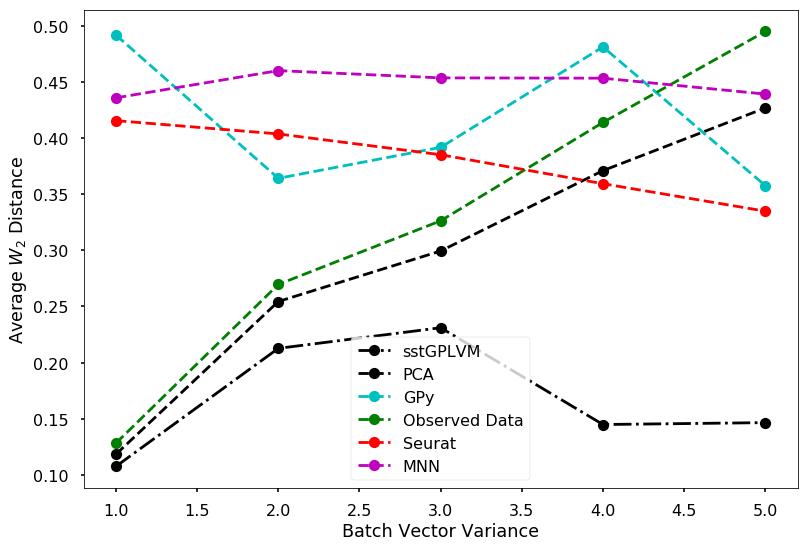

In [39]:
plt.style.use('seaborn-poster')
plt.plot(range(1,6),np.average(w2z[0,:,:],axis = 1),'ko-.', label = 'sstGPLVM')
#plt.plot(range(1,6),np.average(w2r[0,:,:],axis = 1)[0:5],'ko-', label = 'Semi-supervised GPLVM')
plt.plot(range(1,6),np.average(w2p[0,:,:],axis = 1)[0:5],'ko--', label = 'PCA')
plt.plot(range(1,6), np.average(w2gpy[0,:,:], axis = 1)[0:5], 'co--', label = 'GPy')
plt.plot(range(1,6),np.average(w2b,axis = 1)[0:5], 'go--', label = 'Observed Data')
plt.plot(range(1,6),np.average(w2s[0,:,:],axis = 1)[0:5],'ro--', label = 'Seurat')
plt.plot(range(1,6),np.average(w2m[0,:,:],axis = 1)[0:5],'mo--',label = 'MNN')
plt.legend()
plt.xlabel('Batch Vector Variance')
plt.ylabel('Average $W_2$ Distance')
plt.show()

In [ ]:
stdx = 1

plt.errorbar(range(1,6),np.average(w2z[0,:,:],axis = 1),
             yerr = stdx*np.std(w2z[0,:,:],axis = 1),
             fmt = 'ko-.', label = 'Random Init From Latent')
#plt.errorbar(range(1,11),np.average(w2r[0,:,:],axis = 1),
#             yerr = stdx*np.std(w2z[0,:,:],axis = 1),
#             fmt = 'ko-', label = 'PCA Init From Latent')
plt.errorbar(range(1,6),np.average(w2p[0,:,:],axis = 1),
             yerr = stdx*np.std(w2p[0,:,:],axis = 1),
             fmt = 'ko--', label = 'PCA From Latent')
plt.errorbar(range(1,6),np.average(w2b,axis = 1), 
             yerr = stdx*np.std(w2b,axis = 1),
             fmt = 'go--', label = 'Batch Distance')
plt.errorbar(range(1,6),np.average(w2s[0,:,:],axis = 1),
             yerr = stdx*np.std(w2s[0,:,:],axis = 1),
             fmt = 'ro--', label = 'Seurat Distance')
plt.errorbar(range(1,6),np.average(w2m[0,:,:],axis = 1),
             yerr = stdx*np.std(w2m[0,:,:],axis = 1),
             fmt = 'mo--',label = 'MNN Distance')
plt.legend()
plt.xlabel('Variance of Batch Variable')
plt.ylabel('Average $W_2$ Distance')
plt.show()

test clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

In [ ]:
def score_k_means(z,nclusters = 8):
    return_array = np.zeros(2)
    km = KMeans(n_clusters = nclusters)
    labels = km.fit_predict(z)
    true_labels = np.where(clusters_total == 1)[1]
    return_array[0] = normalized_mutual_info_score(labels, true_labels)
    return_array[1] = adjusted_rand_score(labels, true_labels)
    return return_array

In [ ]:
nrepeats = 10
k2z = np.zeros((nrepeats,5,2))
k2p = np.zeros((nrepeats,5,2))
k2s = np.zeros((nrepeats,5,2))
k2m = np.zeros((nrepeats,5,2))
k2b = np.zeros((nrepeats,5,2))
k2gpy = np.zeros((nrepeats,5,2))

for k in range(nrepeats):
    print(k)
    for i in range(1,6):
        Y = np.loadtxt('./'+folder+'/sim-cluster-' + str(i) + '.csv')
        k2b[k,i-1] = score_k_means(Y)



        path = './'+folder+'/matern/rand-lin/' + str(i) + '/model-output-final.hdf5'
        fit = h5py.File(path, 'r')
        zfit = fit['x_mean']
        k2z[k,i-1] = score_k_means(zfit)


        ols = LinearRegression(fit_intercept = False)
        ols.fit(batch_var, Y)
        Yres = Y - ols.predict(batch_var)
        pca = PCA(n_components = 3)
        zpca = pca.fit_transform(Yres)
        k2p[k,i-1] = score_k_means(zpca)

        seurat = pd.read_csv('./'+folder+'/results/seurat-results/sim-' + str(i) + '.csv')
        k2s[k,i-1] = score_k_means(seurat.values)
        
        mnn = pd.read_csv('./'+folder+'/results/mnn-results/sim-' + str(i) + '.csv')
        k2m[k,i-1] = score_k_means(mnn.values)
        
        zfit = gpy_fits[i-1]
        k2gpy[k,i-1] = score_k_means(zfit)

In [ ]:
plt.style.use('seaborn-poster')
plt.plot(range(1,6),np.average(k2z[:,:,0],axis = 0),'ko-.', label = 'sstGPLVM')
plt.plot(range(1,6),np.average(k2p[:,:,0],axis = 0),'ko--', label = 'PCA From Latent')
plt.plot(range(1,6), np.average(k2gpy[:,:,0], axis = 0), 'co--', label = 'GPy')
plt.plot(range(1,6),np.average(k2b[:,:,0],axis = 0), 'go--', label = 'Batch')
plt.plot(range(1,6),np.average(k2s[:,:,0],axis = 0),'ro--', label = 'Seurat Distance')
plt.plot(range(1,6),np.average(k2m[:,:,0],axis = 0),'mo--',label = 'MNN Distance')
plt.legend()
plt.xlabel('Batch Vector Variance')
plt.ylabel('NMI')
plt.show()

In [ ]:
plt.style.use('seaborn-poster')
plt.plot(range(1,6),np.average(k2z[:,:,1],axis = 0),'ko-.', label = 'sstGPLVM')
plt.plot(range(1,6),np.average(k2p[:,:,1],axis = 0),'ko--', label = 'PCA From Latent')
plt.plot(range(1,6), np.average(k2gpy[:,:,1], axis = 0), 'co--', label = 'GPy')
plt.plot(range(1,6),np.average(k2b[:,:,1],axis = 0), 'go--', label = 'Batch')
plt.plot(range(1,6),np.average(k2s[:,:,1],axis = 0),'ro--', label = 'Seurat Distance')
plt.plot(range(1,6),np.average(k2m[:,:,1],axis = 0),'mo--',label = 'MNN Distance')
plt.legend()
plt.xlabel('Batch Vector Variance')
plt.ylabel('ARS')
plt.show()